<a href="https://colab.research.google.com/github/jiminAn/2023_SUMMER_SAMSUNG_DL/blob/main/%EC%8B%A4%EC%8A%B5%EC%9E%90%EB%A3%8C/Day2/Day2_4_Study_Learning_Rate_Scheduler_and_Regularization_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day2.4 Study Learning Rate Scheduler and Regularization Techiques
### 실습 목표
- `Learning rate scheduler`와 `Reguraization techniques`에 대해 알아보고 모델 학습에 적용해보기


## 0. Setting
- DL 관련 library 호출
- GPU 설정

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


## 1. Learning Rate Scheduler
- Learning rate(lr): backpropagation 학습 과정에서 모델의 weight인 gradient의 변화/업데이트 보폭
- Learning rate scheduler: 처음부터 끝까지 같은 lr를 사용할 수도 있지만, 학습과정에서 lr를 조정하는 learning rate scheduler 사용 가능


### optim.lr_scheduler
 - [doc] (https://pytorch.org/docs/stable/optim.html)

 ![image.png](http://drive.google.com/uc?id=1LsHW_g90NRBemBEm-1Bn-0et0qDNyi8v)

 ![image.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbeNGrz%2FbtqQzRMQAQx%2FE5HgPj8oe4AugHgHxS7RlK%2Fimg.png)

 - [ optimizer class ]

 ![image.png](http://drive.google.com/uc?id=1Ab6eMphYOE15DPMd_wBKW0HwsDM6mlfV)

 - [ scheduler function ]

 ![image.png](http://drive.google.com/uc?id=1Ri1piSSdPng993SCk0vGqDGuoiD5aDqd)

 ![image.png](http://drive.google.com/uc?id=1cU3Et1QbKPf4jKoCwK14jDz3SgVkRG8N)

## 2. 모델 구성 및 학습


### 2.1 기본 모델 정의


![image.png](https://blog.kakaocdn.net/dn/b5XcJp/btqWUpKHPTL/wy9Z1Kg41sn6Nbqe2IKBMk/img.png)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)


    def forward(self, x):
        x = x.view(-1, 784) # flatten : (1,28,28) -> (1,784)
        x = F.relu(self.fc1(x)) # (1,784) -> fc1 -> (1, 256)
        x = F.relu(self.fc2(x)) # (1,256) -> fc2 -> (1, 128)
        x = self.fc3(x)  # (1,128) -> fc2 -> (1, 128)

        return x

model = Net().to(DEVICE)

### 2.2 Learning Rate Scheduler 모델에 적용하기

#### optimizer class: SGD(Stochastic Gradient Descent)
- gradient descent를 전체 데이터(batch)가 아닌 일부 데이터의 모음을 사용하는 방법
- ![image.png](https://velog.velcdn.com/images%2Fkyoung99u%2Fpost%2F878fb7c0-1c78-43c8-8455-924895c2cb7d%2Fimage.png)



#### Learning rate scheduler in torch: `optim.lr_scheduler.stepLR(optimizer, step_size, gamma)`
- `optimizer`: 이전에 정의한 optimizer 변수명
- `step_size`: step size마다 gamma 비율로 lr을 감소시큼
- `gamma`: 일정한 Step 마다 lr에 gamma를 곱해주는 방식
- [참고](https://pytorch.org/docs/stable/optim.html)

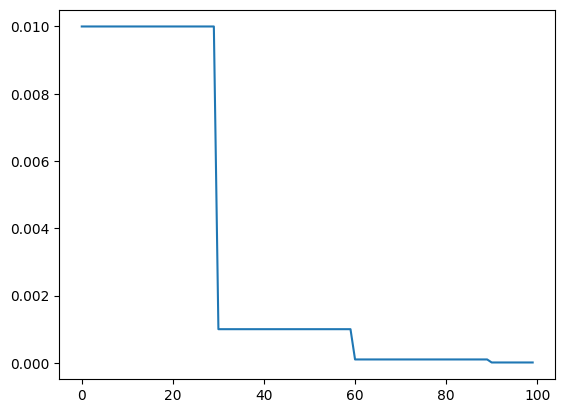

In [ ]:
# Parameter 설정
########################################## Change This Code~!
EPOCHS = 100
LR = 0.01
STEP_SIZE = 30
GAMMA = 0.1
########################################## Change This Code~!

# Optimizer 및 Scheduler 설정
optimizer = optim.SGD(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA) # step size마다 gamma 비율로 lr을 감소시킨다. (step_size 마다 gamma를 곱한다.)

def get_lr(optimizer, scheduler): # Training 코드
    lr = scheduler.get_last_lr()[0]
    optimizer.step()
    scheduler.step() # Scheduler를 사용한다면 필수적으로 들어가야함
    #print(lr)
    return lr

plt.plot(torch.arange(EPOCHS), [get_lr(optimizer, scheduler) for t in range(EPOCHS)])

## 3. Regularization Techniques

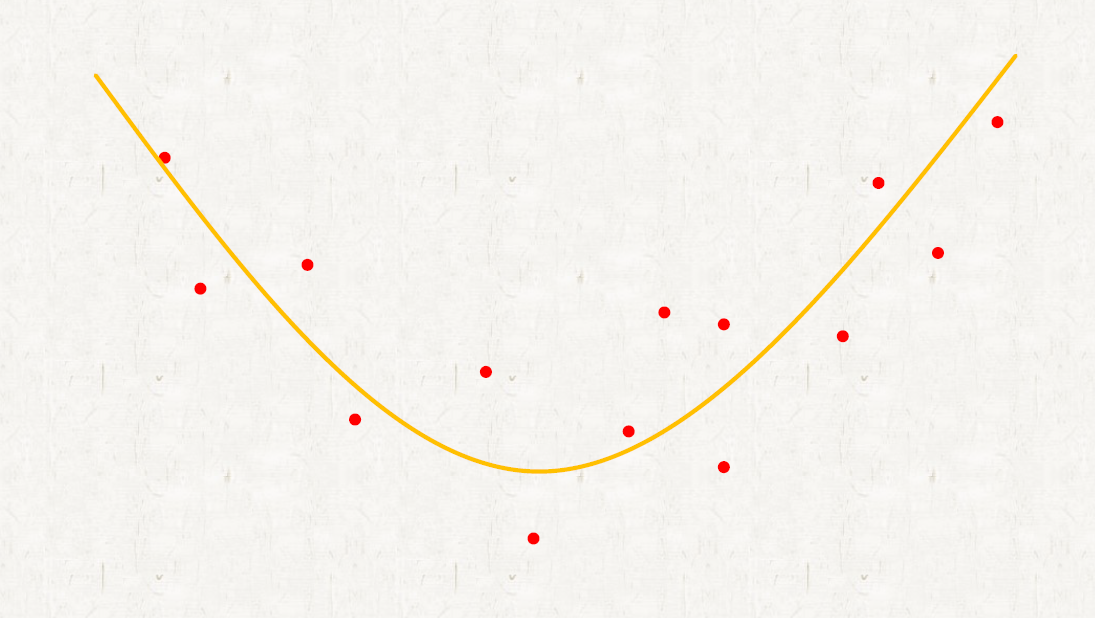

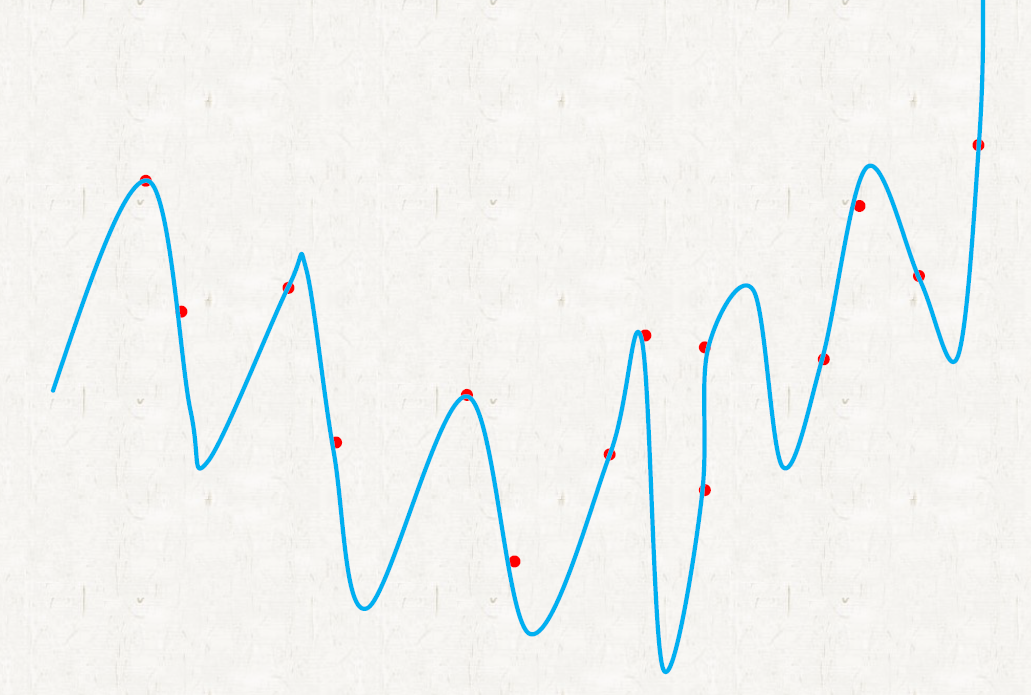

### 3.1 Early Stopping

![image.png](https://miro.medium.com/max/1400/1*06sTlOC3AYeZAjzUDwbaMw@2x.jpeg)

#### Early Stopping Algorithm
- 실제 돌아가는 코드는 아닙니다. 알고리즘 참고용

In [ ]:
# Early Stopping Algorithm
count = 0
valid_acc = 0
for epcho in range(EPOCHS): # training loop
    for idx, (image, target) in enumerate(valid_loader): # at each epoch
        output = model(image) # model inference
        valid_acc = accuracy(output, target) # calculate valid accuracy
        if valid_acc > best_valid_acc: # Valid dataset에 대한 accuracy가 계속 증가하고 있으면 --> count=0, model 저장
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), path) # save best model
            count = 0
        else: # Valid Accuracy가 증가하지 않을 때
            count += 1
            if count >= 3: # 연속 3번 epoch 동안 accuracy가 best accuracy보다 크지 못하다면
                break # Early Stopping Point 이다.

### 3.2 Batch Normalization
![image.png](https://gaussian37.github.io/assets/img/dl/concept/batchnorm/4.png)
- 학습 과정에서 각 배치 단위 별로 데이터가 다양한 분포를 가지더라도 각 배치별로 평균과 분산을 이용해 정규화하는 것을 뜻함.
- batch 단위나 layer에 따라서 입력 값의 분포가 모두 다르지만 정규화를 통하여 분포를 zero mean gaussian 형태로 만듦.
- [내용 참고](https://gaussian37.github.io/dl-concept-batchnorm/)


#### Batch Normalization in torch
- x에 dimension에 따라 `torch.nn.BatchNorm1d`와 `torch.nn.BatchNorm2d`를 구분해서 사용
- [doc] (https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)

 ![image.png](http://drive.google.com/uc?id=1sId2CSNqxKncTueKwgtIoBzEMvSfAvhx)
 ![image.png](http://drive.google.com/uc?id=1fycDf_67C9OBV1GHZBmwD4P83iNtS5XL)

#### Quiz1
- 레이어 구성 순서에 맞게 코드 빈칸을 채워주세요
- Hint: x-> fc(x) -> bath_norm(x) -> activation(x)

 ![image.png](http://drive.google.com/uc?id=1dDAMt76ZNg1stRVXMs_gYrz7CBw-PbmA)


In [ ]:
# Model 설정
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(num_features=256) # x가 2-dim 이면 nn.BatchNorm2d
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(num_features=128) # x가 2-dim 이면 nn.BatchNorm2d
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        ########################################## Change This Code~!
        x = ?? # conv: fc1
        x = ?? # conv: fc2
        ########################################## Change This Code~!
        x = self.fc3(x)
        return x

model = Net().to("cuda")
summary(model, (1, 28, 28))

### 3.3 Dropout : nn.Dropout2d
![imgae.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fm5YtD%2FbtrbwgszFXZ%2FxdUhkeyK2lmrQXYy7HioL0%2Fimg.png)
- 서로 연결된 layer 0~1 사이의 확률로 뉴런을 제거(drop)하는 기법
- ex. drop-out rate가 0.5라고 가정
  - Drop-out 이전에 4개의 뉴런끼리 모두 연결되어 있는 Fully Connected Layer
  - 4개의 뉴런 각각은 0.5의 확률로 제거될지 말지 랜덤하게 결정
  - 사용목적: 특정한 feature만을 과도하게 집중하여 학습함으로써 발생하는 overfitting을 방지하기 위해 사용.
  - 특정 뉴런이 중요한 feature에 집중하게 되면, 해당 뉴런에 연결된 weight만 학습이 되고, 나머지 뉴런은 학습 기회를 잃음 --> 특정 뉴런에 집중되지 않고 여러 뉴런을 골고루 학습시키기 위해 사용.
  - [내용 참고](https://heytech.tistory.com/127)

- [doc] (https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html)

 ![image.png](http://drive.google.com/uc?id=1qYq4XLqNskL8ejGVjFblS9cVfYIJmyHR)
 ![image.png](http://drive.google.com/uc?id=11jcEX8ADdeW4y2U1EnFbk0j2h4OQX9TG)

 #### Quiz2
- 레이어 구성 순서에 맞게 코드 빈칸을 채워주세요
- Hint: x-> fc(x) -> bath_norm(x) -> activation(x) -> dropout(x)
 ![image.png](http://drive.google.com/uc?id=1dDAMt76ZNg1stRVXMs_gYrz7CBw-PbmA)

In [ ]:
# Model 설정
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout = nn.Dropout(p=0.5) # x가 2-dim 이면 nn.Dropout2d
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256) # x가 2-dim 이면 nn.BatchNorm2d
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128) # x가 2-dim 이면 nn.BatchNorm2d
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        ########################################## Change This Code~!
        x = ?? # conv: fc1
        x = ?? # conv: fc2
        ########################################## Change This Code~!
        x = self.fc3(x)
        return x

model = Net().to("cuda")
summary(model, (1, 28, 28))